### Capstone 1: White Wine Quality, UC Irvine
(Source: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009)

# 6c. Random Forest Regressor
## Red Wine, Outliers Removed

#### Audrey Hughes Rager
#### December 30, 2020


In [1]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline

sns.set_style('whitegrid')

## Data Wrangling

### Import Data

In [2]:
#Import csv files into Pandas data frames
df = pd.read_csv('winequality-red.csv',sep=";")
df = df.rename({'fixed acidity': 'fixed_acidity','volatile acidity': 'volatile_acidity', 'citric acid': 'citric_acid', 'residual sugar':'residual_sugar',  'free sulfur dioxide':'free_sulfur_dioxide', 'total sulfur dioxide':'total_sulfur_dioxide'}, axis=1)



### Remove Outliers

In [3]:
# Filtering Values between Q1-1.5IQR and Q3+1.5IQR
ValueList = ('fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides',
            'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol')

for myValue in ValueList:
    #compute range of data
    myValueMax = df[myValue].max()
    myValueMin = df[myValue].min()
    myValueRange = myValueMax - myValueMin
    
    # Computing IQR
    Q1 = df[myValue].quantile(0.25)
    Q3 = df[myValue].quantile(0.75)
    IQR = Q3 - Q1
    gtdropvalue = (Q3 + (1.5 * IQR))
    ltdropvalue = (Q1 - (1.5 * IQR))
    
    index_names_right = df[df[myValue] >= gtdropvalue].index
    index_names_left = df[df[myValue] <= ltdropvalue].index
    df.drop(index_names_right, inplace = True)
    df.drop(index_names_left, inplace = True)
    print(myValue + ' maximum: ' + str(myValueMax))
    print(myValue + ' minimum: ' + str(myValueMin))
    print(myValue + ' Q1: ' + str(Q1))
    print(myValue + ' Q3: ' + str(Q3))
    print(myValue + ' range: ' + str(myValueRange))
    print(myValue + ' IQR: ' + str(IQR))
    print('ratio of Range fo IQR: ' + str(myValueRange/IQR))
    print()
    
   

fixed_acidity maximum: 15.9
fixed_acidity minimum: 4.6
fixed_acidity Q1: 7.1
fixed_acidity Q3: 9.2
fixed_acidity range: 11.3
fixed_acidity IQR: 2.0999999999999996
ratio of Range fo IQR: 5.380952380952382

volatile_acidity maximum: 1.58
volatile_acidity minimum: 0.12
volatile_acidity Q1: 0.395
volatile_acidity Q3: 0.64
volatile_acidity range: 1.46
volatile_acidity IQR: 0.245
ratio of Range fo IQR: 5.959183673469388

citric_acid maximum: 1.0
citric_acid minimum: 0.0
citric_acid Q1: 0.09
citric_acid Q3: 0.41
citric_acid range: 1.0
citric_acid IQR: 0.31999999999999995
ratio of Range fo IQR: 3.1250000000000004

residual_sugar maximum: 15.5
residual_sugar minimum: 0.9
residual_sugar Q1: 1.9
residual_sugar Q3: 2.6
residual_sugar range: 14.6
residual_sugar IQR: 0.7000000000000002
ratio of Range fo IQR: 20.85714285714285

chlorides maximum: 0.611
chlorides minimum: 0.012
chlorides Q1: 0.07
chlorides Q3: 0.08900000000000001
chlorides range: 0.599
chlorides IQR: 0.019000000000000003
ratio of Rang

### EDA


In [4]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000,1135.000000
mean,8.146784,0.522211,0.246000,2.180617,0.078296,14.788546,40.946256,0.996569,3.325286,0.628405,10.353377,5.637004
std,1.444025,0.164683,0.180343,0.439189,0.013741,8.587718,24.625658,0.001558,0.130173,0.112067,0.953617,0.758518
min,5.100000,0.120000,0.000000,1.200000,0.042000,1.000000,6.000000,0.992560,2.980000,0.330000,8.700000,3.000000
25%,7.100000,0.390000,0.080000,1.900000,0.069000,8.000000,22.000000,0.995515,3.230000,0.550000,9.500000,5.000000
50%,7.800000,0.520000,0.240000,2.100000,0.078000,13.000000,35.000000,0.996600,3.330000,0.610000,10.100000,6.000000
75%,9.000000,0.630000,0.390000,2.400000,0.087000,20.000000,54.000000,0.997500,3.400000,0.700000,11.000000,6.000000
max,12.300000,1.005000,0.730000,3.600000,0.116000,40.000000,113.000000,1.000400,3.680000,0.940000,13.000000,8.000000


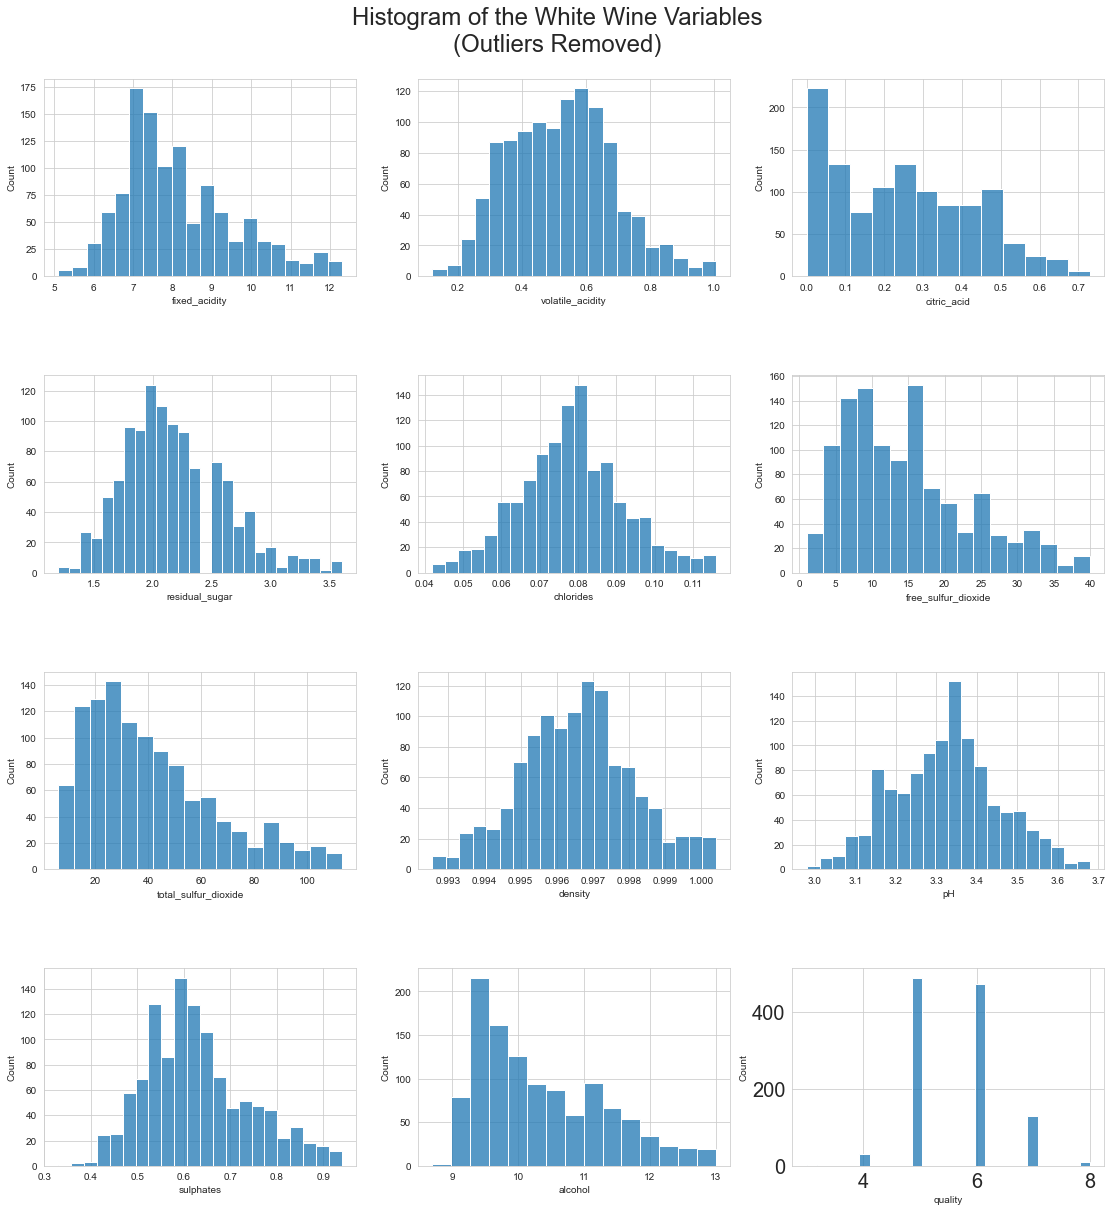

In [5]:
#Historgrams  - outliers removed (df)
def subplot_histplot(data, row = 4, column = 3, title = "Subplots", height = 20, width = 19):
    # Create a figure instance, and the subplots
    fig = plt.figure(figsize = (width, height))
    fig.suptitle(title, fontsize=24, y = 0.93)
    # Run loop over the all the variables
    for i in range(data.shape[1]):
        # Create the axis line
        ax = fig.add_subplot(row, column, i + 1)
        fig.subplots_adjust(hspace = .5)
        # Create histogram for each variable
        plot = sns.histplot(df.iloc[:, i], ax=ax)
    # Show the plot
    plot.tick_params(labelsize = 20)
    plt.show()

plot_columns = ['quality','fixed_acidity','volatile_acidity', 'citric_acid', 'residual_sugar','chlorides','free_sulfur_dioxide','total_sulfur_dioxide','density', 'pH', 'sulphates','alcohol']
    


myhistplot = subplot_histplot(df[plot_columns], row = 4, column = 3, title = "Histogram of the White Wine Variables\n(Outliers Removed)")


### Train-Test-Split

In [6]:
#Independent variables (X) = everything but the target variable, y
#Target variable, y, is quality

#Set X to all the input variables (everything except 'quality')
X = df.drop('quality',axis=1)

#Set the variable to be predicted (y) to 'quality'
y = df['quality']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=42)


### Scale Independent Variables

In [8]:
# applying Standard Scaling to the dataset to scale all the field values to same scale (approx.).

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)



# RandomForestRegressor

sklearn.ensemble.RandomForestRegressor(n_estimators=100, *, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0.0, max_samples=None)

# Instantiate the Random Forest Regressor Model

In [9]:
rfr = RandomForestRegressor(n_estimators = 200, max_depth=20, min_samples_leaf=50, random_state = 42)

# Fit the Model to the Training Data

In [10]:
rfrModel = rfr.fit(X_train,y_train)

# Predict Using Test Data

In [11]:
y_pred = rfrModel.predict(X_test)

In [12]:
print(y_pred)

[5.38350353 6.29002098 5.06043962 5.11130688 6.51691117 5.28667658
 5.15021162 5.23325777 5.40263585 5.62688528 5.81388612 5.19527467
 6.35085375 6.52456393 6.36465895 5.28342694 5.63666745 5.8200268
 6.37750842 5.54692402 5.36164266 6.13368705 5.62688528 5.60209119
 5.21168883 5.29308877 5.19027338 5.15129706 6.31669003 5.20593631
 5.20098781 5.23203724 5.0882404  5.6716963  5.6565793  5.56125197
 6.15181072 5.19736798 5.49299579 5.83025331 5.72614511 5.5556751
 5.96768392 5.19550694 5.63641601 6.50880455 5.26144701 6.30430327
 5.25649929 6.18942848 6.18448799 5.11886149 5.84251918 5.39309193
 6.01182893 5.16002801 5.74419152 5.14965548 4.99141387 5.58432473
 5.63641601 5.64140587 5.7043624  5.69485951 6.05180465 6.41925403
 4.99956982 6.43144561 4.99075391 5.5438824  5.15021162 5.99948317
 5.35707139 5.74563909 5.43772847 5.52821995 5.33029912 5.19403537
 6.4912708  5.18947609 5.77424641 5.23325777 5.27798125 5.77189035
 5.91592726 5.6565793  6.31872177 5.3554782  5.66136923 5.774246

In [13]:
print(rfr.predict([[0,0,0,0,0,0,0,0,0,0,0]]))

[5.6260814]


In [14]:
print(rfrModel.predict([[0,0,0,0,0,0,0,0,0,0,0]]))

[5.6260814]


# Evaluate Model

In [15]:
mae_r = mean_absolute_error(y_test,y_pred)
mse_r = mean_squared_error(y_test,y_pred)

In [16]:
print("Mean Absolute Error (MAE):",round(mae_r,4))
print("Mean Squared Error (MSE):",round(mse_r,4))


Mean Absolute Error (MAE): 0.4635
Mean Squared Error (MSE): 0.3215


In [17]:
importance = rfrModel.feature_importances_
importance

array([0.00147952, 0.10707699, 0.00797867, 0.00070282, 0.00251431,
       0.00323138, 0.01046969, 0.01248349, 0.01226317, 0.27170039,
       0.57009956])

In [18]:
columns = X.columns

In [19]:
rfrGraph = pd.Series(importance,columns)
rfrGraph

fixed_acidity           0.001480
volatile_acidity        0.107077
citric_acid             0.007979
residual_sugar          0.000703
chlorides               0.002514
free_sulfur_dioxide     0.003231
total_sulfur_dioxide    0.010470
density                 0.012483
pH                      0.012263
sulphates               0.271700
alcohol                 0.570100
dtype: float64

[Text(0.5, 1.0, 'White Wine Quality - Random Forest Regressor Model Visualization (Outliers Removed)')]

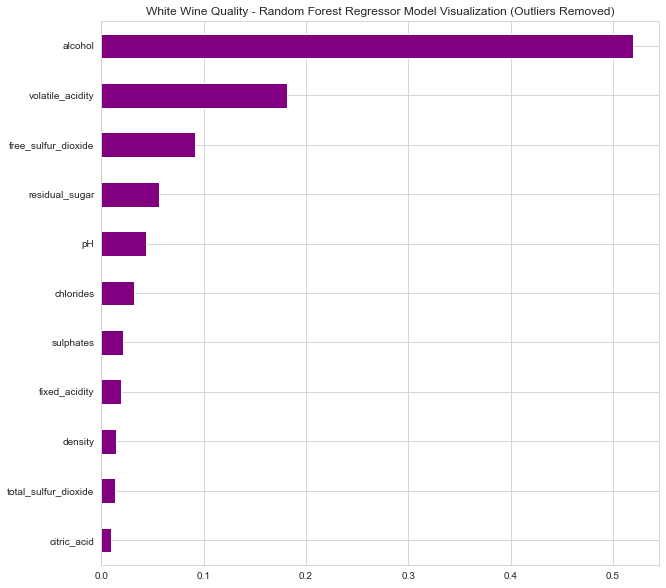

In [46]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10,10))

rfrGraph.sort_values().plot.barh(color="purple")

[plt.title("White Wine Quality - Random Forest Regressor Model Visualization (Outliers Removed)")]